In [43]:
# import packages 
import numpy as np 

import h5py
import os
import re

import pickle

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer02.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 15*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

# full_page_figure_illustrator_size_pxls = np.array([521, 660])
# full_page_paper_illustrator_size_pxls = np.array([612, 792])
# paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls

full_page_figure_illustrator_size_pxls = np.array([521, 655])
full_page_paper_illustrator_size_pxls = np.array([620, 801])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls

plot_panel_label_font_size = 8
plot_axis_label_font_size = 7
plot_numeric_label_font_size = 6.5

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer02_2024-05-13.py


In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl_colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 14.13 s


In [5]:
def draw_orientation_symbol_arrow_ospolar(size, orientation_rad, offset_xy, plot_ax = None):
    plot_linewidth = 0.75
    base_rot_angle_rad = -np.pi/2
    
    orientation_rad += base_rot_angle_rad
    rot_matrix = np.array([[1, 0], [0, 1]])*np.cos(-orientation_rad) + np.array([[0, -1],[1, 0]])*np.sin(-orientation_rad)

    base_plot_h_line_len = 6
    base_plot_h_line_separation = 2
    base_plot_nof_h_lines = 2
    base_plot_v_line_len = 6
    base_plot_offset_xys = np.array([0, -base_plot_v_line_len/2], dtype = float)
    base_plot_arrow_head_width = 2

    plot_h_line_width = 1
    plot_v_line_width = 0.5
    plot_arrow_line_width = 0.5
    
    base_plot_h_lines = [None for _ in range(base_plot_nof_h_lines)]
    for i_h_line in range(base_plot_nof_h_lines):
        cur_base_h_line = np.array([[-3,0],[3,0]], dtype = float)
        cur_base_h_line += np.array([[0, base_plot_h_line_separation * i_h_line]])
        base_plot_h_lines[i_h_line] = cur_base_h_line
    base_plot_h_line_wdiths = [plot_h_line_width for _ in range(len(base_plot_h_lines))]

    base_plot_v_line = np.array([[0, 0,], [0, base_plot_v_line_len]], dtype = float)
    
    base_plot_arrow_head_line = np.array([[-base_plot_arrow_head_width, base_plot_v_line_len - base_plot_arrow_head_width],
                                          [0, base_plot_v_line_len],
                                          [base_plot_arrow_head_width, base_plot_v_line_len - base_plot_arrow_head_width],],
                                          dtype = float)
        
    base_plot_lines = base_plot_h_lines + [base_plot_v_line, base_plot_arrow_head_line]
    base_plot_line_widths = base_plot_h_line_wdiths + [plot_v_line_width, plot_arrow_line_width]

    for i_line in range(len(base_plot_lines)):
        cur_base_plot_line = base_plot_lines[i_line]
        cur_base_plot_line += base_plot_offset_xys.reshape((1,-1))
        base_plot_lines[i_line] = cur_base_plot_line

    plot_lines = [None for _ in range(len(base_plot_lines))]
    for i_line in range(len(base_plot_lines)):
        cur_plot_line = base_plot_lines[i_line]
        cur_plot_line = cur_plot_line * size
        cur_plot_line = cur_plot_line @ rot_matrix
        cur_plot_line += offset_xy.reshape((1,-1))
        plot_lines[i_line] = cur_plot_line

    # plot_ax = plt.gca()
    for i_line in range(len(plot_lines)):
        cur_plot_line = plot_lines[i_line]
        cur_plot_linewidth = base_plot_line_widths[i_line]
        plot_ax.plot(cur_plot_line[:,0], cur_plot_line[:,1],
                     color = "black",
                     linewidth = cur_plot_linewidth,
                     clip_on = False,
                     # clip_on = True,
                    )

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 16.02 s


In [6]:
def draw_orientation_symbol(size, orientation_rad, offset_xy, plot_ax = None):
    # rot_matrix = np.array([[1, 0], [0, 1]])*np.cos(orientation_rad) + np.array([[0, -1],[1, 0]])*np.sin(orientation_rad)
    rot_matrix = np.array([[1, 0], [0, 1]])*np.cos(-orientation_rad) + np.array([[0, -1],[1, 0]])*np.sin(-orientation_rad)
    
    base_plot_v_line_xys = np.array([[-0.2,-1], [-0.2,1]]) 
    base_plot_h_line_xys = np.array([[-0.2,0],[1,0]])

    base_plot_v_line_xys = base_plot_v_line_xys * size 
    base_plot_h_line_xys = base_plot_h_line_xys * size 

    base_plot_v_line_xys = base_plot_v_line_xys @ rot_matrix
    base_plot_h_line_xys = base_plot_h_line_xys @ rot_matrix

    base_plot_v_line_xys += offset_xy.reshape((1,-1))
    base_plot_h_line_xys += offset_xy.reshape((1,-1))

    if plot_ax is None:
        plot_ax = plt.gca()

    plot_ax.plot(base_plot_v_line_xys[:,0], 
             base_plot_v_line_xys[:,1],
             color = "black")
    plot_ax.plot(base_plot_h_line_xys[:,0],
             base_plot_h_line_xys[:,1],
             color = "black")

def draw_orientation_symbol_arrow(size, orientation_rad, offset_xy, plot_ax = None):
    plot_linewidth = 0.75
    base_rot_angle_rad = -np.pi/2
    
    orientation_rad += base_rot_angle_rad
    rot_matrix = np.array([[1, 0], [0, 1]])*np.cos(-orientation_rad) + np.array([[0, -1],[1, 0]])*np.sin(-orientation_rad)

    base_plot_h_line_len = 6
    base_plot_h_line_separation = 2
    base_plot_nof_h_lines = 2
    base_plot_v_line_len = 6
    base_plot_offset_xys = np.array([0, -base_plot_v_line_len/2], dtype = float)
    base_plot_arrow_head_width = 2

    plot_h_line_width = 1
    plot_v_line_width = 0.5
    plot_arrow_line_width = 0.5
    
    base_plot_h_lines = [None for _ in range(base_plot_nof_h_lines)]
    for i_h_line in range(base_plot_nof_h_lines):
        cur_base_h_line = np.array([[-3,0],[3,0]], dtype = float)
        cur_base_h_line += np.array([[0, base_plot_h_line_separation * i_h_line]])
        base_plot_h_lines[i_h_line] = cur_base_h_line
    base_plot_h_line_wdiths = [plot_h_line_width for _ in range(len(base_plot_h_lines))]

    base_plot_v_line = np.array([[0, 0,], [0, base_plot_v_line_len]], dtype = float)
    
    base_plot_arrow_head_line = np.array([[-base_plot_arrow_head_width, base_plot_v_line_len - base_plot_arrow_head_width],
                                          [0, base_plot_v_line_len],
                                          [base_plot_arrow_head_width, base_plot_v_line_len - base_plot_arrow_head_width],],
                                          dtype = float)
        
    base_plot_lines = base_plot_h_lines + [base_plot_v_line, base_plot_arrow_head_line]
    base_plot_line_widths = base_plot_h_line_wdiths + [plot_v_line_width, plot_arrow_line_width]

    for i_line in range(len(base_plot_lines)):
        cur_base_plot_line = base_plot_lines[i_line]
        cur_base_plot_line += base_plot_offset_xys.reshape((1,-1))
        base_plot_lines[i_line] = cur_base_plot_line

    plot_lines = [None for _ in range(len(base_plot_lines))]
    for i_line in range(len(base_plot_lines)):
        cur_plot_line = base_plot_lines[i_line]
        cur_plot_line = cur_plot_line * size
        cur_plot_line = cur_plot_line @ rot_matrix
        cur_plot_line += offset_xy.reshape((1,-1))
        plot_lines[i_line] = cur_plot_line

    # plot_ax = plt.gca()
    for i_line in range(len(plot_lines)):
        cur_plot_line = plot_lines[i_line]
        cur_plot_linewidth = base_plot_line_widths[i_line]
        plot_ax.plot(cur_plot_line[:,0], cur_plot_line[:,1],
                     color = "black",
                     linewidth = cur_plot_linewidth,
                     clip_on = False,
                     # clip_on = True,
                    )

def imshow_blank_stim_sequence(imshape, stim_tstamps, plot_ax = None):
    disp_vmin = 0
    disp_vmax = 1
    disp_cmap = "gray"
    
    stim_seq_img = np.zeros(imshape)
    nof_stims, nof_steps, nof_tstamp = stim_tstamps.shape
    
    stim_fill_vals = np.zeros((nof_stims, nof_steps))
    stim_fill_vals[:,1] = 1

    plot_orient_step = (2*np.pi)/nof_stims
    plot_orient_offet = 0
    # plot_orients = np.linspace(0, 360, nof_stims)
    plot_orients = plot_orient_offet + np.arange(nof_stims) * plot_orient_step
    # print(plot_orients)
    
    for i_stim in range(nof_stims):
        for i_step in range(nof_steps):
            tstamp_start, tstamp_end = stim_tstamps[i_stim, i_step, :]
            tstamp_start = max(tstamp_start, 0)
            tstamp_end = min(tstamp_end, imshape[-1])
            if tstamp_end < tstamp_start:
                continue
            stim_seq_img[:, tstamp_start:tstamp_end] = stim_fill_vals[i_stim, i_step]

    if plot_ax is None:
        plot_ax = plt.gca()
    
    plot_ax.imshow(stim_seq_img, 
               cmap = disp_cmap,
               vmin = disp_vmin,
               vmax = disp_vmax,
               interpolation = "none",
               aspect = "auto")
    plot_ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    
    for i_stim in range(nof_stims):
        tstamp_start, tstamp_end = stim_tstamps[i_stim, 1, :]
        tstamp_start = max(tstamp_start, 0)
        tstamp_end = min(tstamp_end, imshape[-1])
        if tstamp_end < tstamp_start:
            continue
        draw_orientation_symbol(imshape[0]/2, 
                                plot_orients[i_stim],
                                np.array([(tstamp_start + tstamp_end)/2, imshape[0]/2]),
                                plot_ax,
                               )
    plot_ax.set_xlim(left = 0, 
                     right = imshape[1]
                    )
    plot_ax.set_ylim(bottom = 0, 
                     top = imshape[0]
                    )

def imshow_blank_stim_sequence_arrow(imshape, stim_tstamps, plot_ax = None):
    disp_vmin = 0
    disp_vmax = 1
    disp_cmap = "gray"
    
    stim_seq_img = np.zeros(imshape)
    # stim_seq_img = np.full(imshape, 0.75)
    
    nof_stims, nof_steps, nof_tstamp = stim_tstamps.shape
    
    # stim_fill_vals = np.zeros((nof_stims, nof_steps))
    stim_fill_vals = np.full((nof_stims, nof_steps), 0.6)
    stim_fill_vals[:,1] = 1

    plot_orient_step = (2*np.pi)/nof_stims
    plot_orient_offet = 0
    # plot_orients = np.linspace(0, 360, nof_stims)
    plot_orients = plot_orient_offet + np.arange(nof_stims) * plot_orient_step
    # print(plot_orients)
    
    for i_stim in range(nof_stims):
        for i_step in range(nof_steps):
            tstamp_start, tstamp_end = stim_tstamps[i_stim, i_step, :]
            tstamp_start = max(tstamp_start, 0)
            tstamp_end = min(tstamp_end, imshape[-1])
            if tstamp_end < tstamp_start:
                continue
            stim_seq_img[:, tstamp_start:tstamp_end] = stim_fill_vals[i_stim, i_step]

    if plot_ax is None:
        plot_ax = plt.gca()
    
    plot_ax.imshow(stim_seq_img, 
               cmap = disp_cmap,
               vmin = disp_vmin,
               vmax = disp_vmax,
               interpolation = "none",
               aspect = "auto")
    plot_ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    # plot_ax.axes.get_yaxis().set_ticks([])
    # plot_ax.axes.get_xaxis().set_ticks([])
    # plot_ax.spines['top'].set_visible(False)
    # plot_ax.spines['right'].set_visible(False)
    # plot_ax.spines['bottom'].set_visible(False)
    # plot_ax.spines['left'].set_visible(False)

    plot_ax.set_xlim(left = 0, 
                     right = imshape[1]
                    )
    plot_ax.set_ylim(bottom = 0, 
                     top = imshape[0]
                    )
    
    plot_inset_ax = plot_ax.inset_axes([0, 0, 1, 1])

    for i_stim in range(nof_stims):
        tstamp_start, tstamp_end = stim_tstamps[i_stim, 1, :]
        tstamp_start = max(tstamp_start, 0)
        tstamp_end = min(tstamp_end, imshape[-1])
        if tstamp_end < tstamp_start:
            continue
        draw_orientation_symbol_arrow(imshape[0]/6.5, 
                                      plot_orients[i_stim],
                                      np.array([(tstamp_start + tstamp_end)/2, imshape[0]/2]),
                                      plot_inset_ax,
                                     )
    plot_inset_ax.set_xlim(left = 0, 
                           right = imshape[1]
                           )
    plot_inset_ax.set_ylim(bottom = 0, 
                           top = imshape[0]
                           )
    # plot_inset_ax.axis("equal") 
    plot_inset_ax.set_aspect('equal',adjustable='box')
    # plot_inset_ax.axes.get_yaxis().set_ticks([])
    # plot_inset_ax.axes.get_xaxis().set_ticks([])
    plot_inset_ax.spines['top'].set_visible(False)
    plot_inset_ax.spines['right'].set_visible(False)
    plot_inset_ax.spines['bottom'].set_visible(False)
    plot_inset_ax.spines['left'].set_visible(False)
    plot_inset_ax.tick_params(left=False,
                              bottom=False,
                              labelleft=False,
                              labelbottom=False)
    plot_inset_ax.patch.set_alpha(0)


    # plot_ax.axis("equal")


SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 50.63 s


In [7]:
# create customized colormap

truncate_pink = truncate_colormap(plt.get_cmap("pink"), 0.2, 1)
truncate_pink_r = truncate_colormap(plt.get_cmap("pink_r"), 0, 0.8)
truncate_gray = truncate_colormap(plt.get_cmap("gray"), 0.2, 1)

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer02_2024-05-13.py


In [8]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

# bw_order = 12
# bw_cutoff = 50

bw_order = 5
bw_cutoff = 20

fs = 1 * s_to_ms / time_per_frame_ms

real_period_s = 1.0109
ideal_period_s = 1
real_timing_correct_ratio = real_period_s/ideal_period_s

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer02_2024-05-13.py


[  0.  45.  90. 135. 180. 225. 270. 315.]
1.0
(8, 3, 2)
Time since last sync = 12.95 s


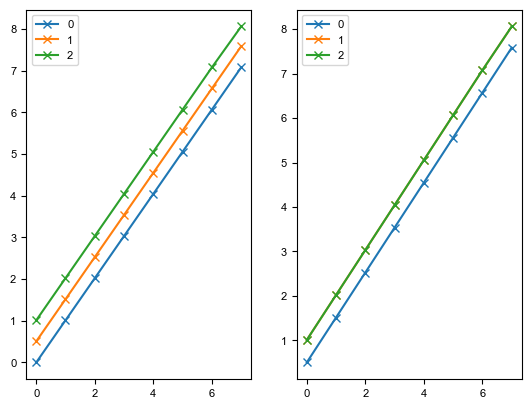

In [9]:
# ordered visual stimulation configuration (only works for one repetition)
ideal_static_moving_t_s = np.array([0.5, 0.5, 0])
# ideal_static_moving_t_s = np.array([0.25, 0.75, 0]) # updated blank and stimulation calculation time stamps
# ideal_static_moving_t_s = np.array([0.25, 0.5, 0.25])

# correct timing from statistical analysis of the record result
static_moving_t_s = ideal_static_moving_t_s

nof_orient = 8

orient_angles_deg = np.arange(nof_orient) * (360/nof_orient)
orient_angles_rad = orient_angles_deg * (np.pi/180)
 
print(orient_angles_deg)

# conversion
nof_stim_steps = static_moving_t_s.size
tot_trail_t_s = np.sum(static_moving_t_s)

view_stim_tstamp_s = np.zeros((nof_orient, nof_stim_steps, 2))

cur_start_t_s = np.arange(nof_orient) * tot_trail_t_s
for i_step in range(nof_stim_steps):
    view_stim_tstamp_s[:, i_step, 0] = cur_start_t_s
    cur_start_t_s = cur_start_t_s + static_moving_t_s[i_step]
    view_stim_tstamp_s[:, i_step, 1] = cur_start_t_s

print(tot_trail_t_s)
print(view_stim_tstamp_s.shape)

# view_stim_tstamp_s = 0.25 + view_stim_tstamp_s # updated blank and stimulation calculation time stamps

view_stim_tstamp_s = view_stim_tstamp_s * real_timing_correct_ratio

# view_stim_tstamp_s[view_stim_tstamp_s > 8] = 8 # updated blank and stimulation calculation time stamps
view_stim_tstamp_s[view_stim_tstamp_s > (3100-1)*2.6*1E-3] = (3100-1)*2.6*1E-3 # updated blank and stimulation calculation time stamps

plt.figure()
for i in range(2):
    plt.subplot(1,2,i + 1)
    for i_step in range(nof_stim_steps):
        plt.plot(view_stim_tstamp_s[:,i_step,i], "-x", label = f"{i_step}")
    plt.legend()
    
view_stim_tstamp = (view_stim_tstamp_s * s_to_ms)/time_per_frame_ms
view_stim_tstamp = view_stim_tstamp.astype(int)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

In [10]:
src_hdf5_file_path = r"M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\stats_analysis_data.hdf5"

dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "figures_tmp"

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 26.72 s


In [11]:
# load source data 

nof_rois = None
nof_trials = None
nof_frames = None
nof_orient = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_vec_sum_ang = None
snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None


with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
    print(hdf5_file["src_sub_dir_name"][()])
    
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_vec_sum_ang[i_roi] = hdf5_file[os.path.join(cur_roi_str, "vec_sum_complex.ang")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

b'VolpyResults_Ver01p6_NewMasNewkMC_STD5'
Time since last sync = 49.44 s


In [12]:
print(t_test_pass_mask.size)
print(np.sum(t_test_pass_mask))
print(np.sum(diff_t_test_pass_mask))
print(np.sum(np.logical_and(t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(t_test_pass_mask, diff_anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, diff_anova_test_pass_mask)))

SAVE_PROGRESS(HISTORY_FILEPATH)

156
57
62
18
17
10
10
Time since last sync = 55.18 s


In [13]:
# generate test mask for displaying data

test_mask = diff_t_test_pass_mask
# test_mask = np.logical_and(test_mask,anova_test_pass_mask)

print(np.sum(test_mask))
print(repr(np.where(test_mask)))

masked_spike_events = roi_spike_events[test_mask, :, :]
masked_subthd_dFFs = roi_subthd_dFFs[test_mask, :, :]
masked_dFFs = dFF_s[test_mask,:,:]
masked_vec_sum_angle = roi_vec_sum_ang[test_mask]
masked_t_s = t_s[test_mask,:,:]
masked_F0_s = F0_s[test_mask,:,:]
masked_raw_dFFs = raw_dFFs[test_mask,:,:]

print(masked_spike_events.shape)
print(masked_subthd_dFFs.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

62
(array([  1,   8,  12,  13,  20,  21,  24,  25,  26,  27,  28,  30,  31,
        32,  33,  34,  36,  37,  38,  41,  42,  47,  50,  52,  54,  58,
        60,  61,  63,  66,  69,  70,  71,  73,  76,  77,  79,  81,  84,
        85,  86,  94,  98,  99, 101, 102, 105, 106, 107, 108, 111, 113,
       114, 115, 117, 126, 127, 142, 145, 146, 149, 154], dtype=int64),)
(62, 16, 3100)
(62, 16, 3100)
Time since last sync = 71.65 s


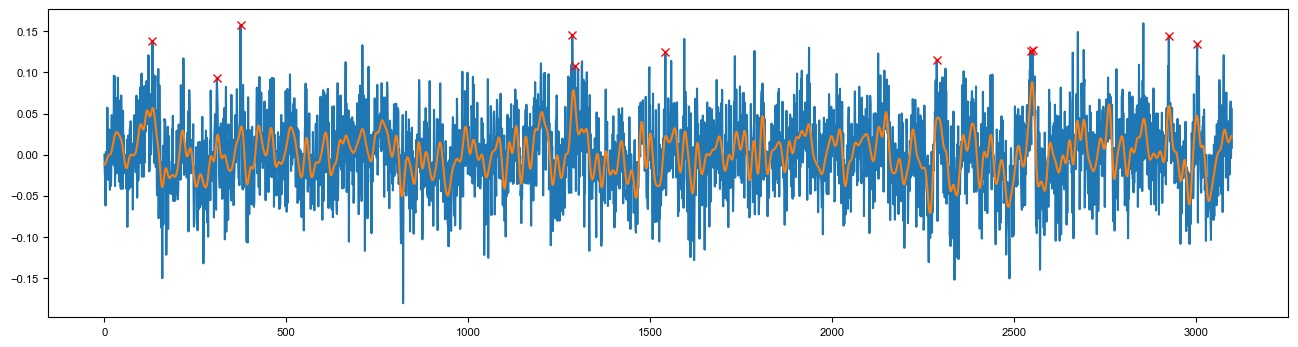

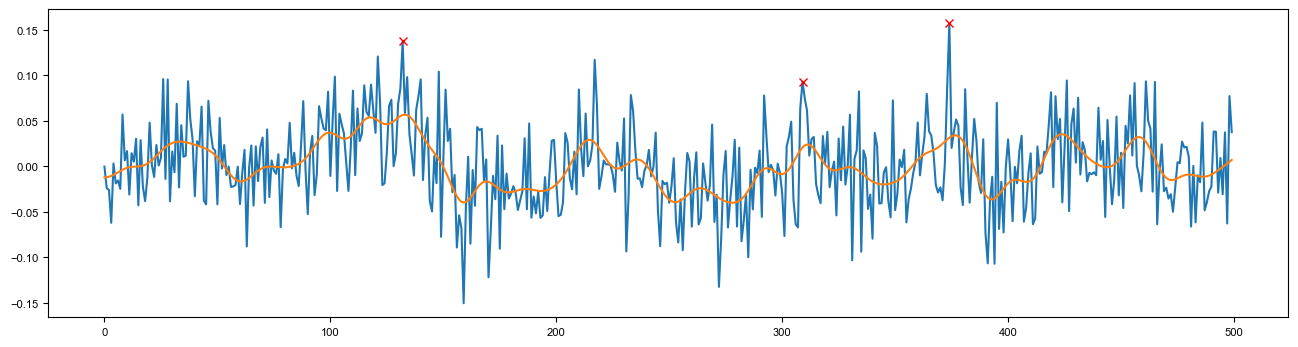

Time since last sync = 80.26 s


In [14]:
# check loaded data
check_i_roi = 32
check_i_trial = 1

plot_x_range = [300, 800]


check_dFF =  dFF_s[check_i_roi, check_i_trial, :]
check_dFF_subthd = roi_subthd_dFFs[check_i_roi, check_i_trial, :]
check_spike_mask = roi_spike_events[check_i_roi, check_i_trial, :]

plot_xs = np.arange(len(check_dFF))

plot_spike_xs = plot_xs.copy().astype(float)
plot_spike_ys = check_dFF.copy().astype(float)
plot_spike_xs[check_spike_mask <= 0] = np.nan
plot_spike_ys[check_spike_mask <= 0 ] = np.nan
# plot_spike_xs = plot_xs[check_spike_mask > 0]
# plot_spike_ys = check_dFF[check_spike_mask > 0]

plt.figure(figsize = (16,4))
plt.plot(plot_xs, check_dFF)
plt.plot(plot_xs, check_dFF_subthd)
plt.plot(plot_spike_xs, plot_spike_ys, "rx")
plt.show()

zoom_x_range = np.arange(0, 500)
plt.figure(figsize = (16,4))
plt.plot(plot_xs[zoom_x_range], check_dFF[zoom_x_range])
plt.plot(plot_xs[zoom_x_range], check_dFF_subthd[zoom_x_range])
plt.plot(plot_spike_xs[zoom_x_range], plot_spike_ys[zoom_x_range], "rx")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [148]:
dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp
Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer02_2024-05-13.py


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pickle dump to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp\ve_spike_subthd_raster_plot.pickle
plot saved to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp\ve_spike_subthd_raster_plot.pdf


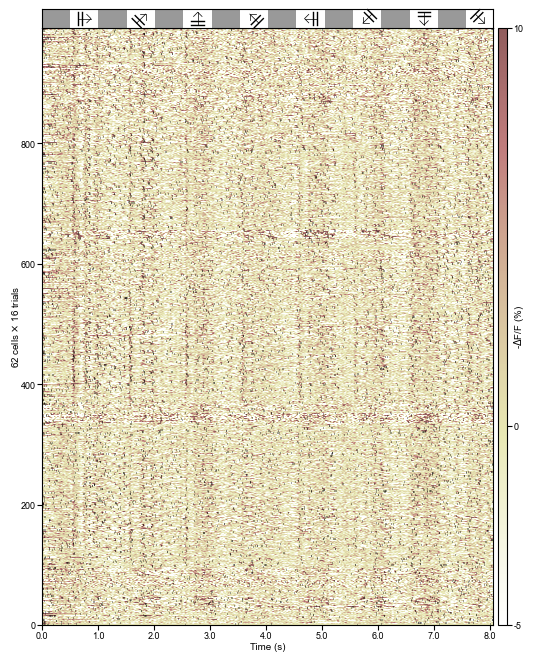

Time since last sync = 417.78 s


In [162]:
plot_vmin = -0.05
plot_vmax = +0.1
plot_cmap = truncate_pink_r
plot_spike_color = "black"

input_spike_events = masked_spike_events
input_subthd_dFFs = masked_subthd_dFFs

plot_spike_events = input_spike_events.reshape((-1, input_spike_events.shape[-1]))
plot_subthd_dFFs = input_subthd_dFFs.reshape((-1, input_subthd_dFFs.shape[-1]))
plot_stim_tstamps = stim_tstamp

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_blank_stim_seq_tstamps = view_stim_tstamp
plot_blank_stim_seq_shape = np.array([80, plot_subthd_dFFs.shape[-1]])

plot_mainfig_inset_axis_bounds = np.array([0, 0, 0.97, 0.97])
plot_colorbar_inset_axis_bounds = np.array([1 - 0.02, 
                                            plot_mainfig_inset_axis_bounds[1],
                                            0.02,
                                            plot_mainfig_inset_axis_bounds[3],
                                            ])
plot_blank_stim_seq_inset_axis_bounds = np.array([0, 
                                                  plot_mainfig_inset_axis_bounds[3], 
                                                  plot_mainfig_inset_axis_bounds[2], 
                                                  1 - plot_mainfig_inset_axis_bounds[3],
                                                  ])
plot_blank_stim_seq_shape[0] = plot_blank_stim_seq_shape[1] * plot_blank_stim_seq_inset_axis_bounds[-1]/plot_blank_stim_seq_inset_axis_bounds[-2]
plot_blank_stim_seq_shape = plot_blank_stim_seq_shape.astype(int)
        
plot_y_ticks = np.arange(0, plot_subthd_dFFs.shape[0], 2E2)
# plot_y_tick_labels = [f"{i_k} k" for i_k in (plot_y_ticks/1E3).astype(float)]
plot_y_tick_labels = [f"{i_num}" for i_num in plot_y_ticks.astype(int)]

dst_figure_name = f"ve_spike_subthd_raster_plot"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (6,8))
plot_ax = plt.gca()
plot_ax.axes.get_yaxis().set_ticks([])
plot_ax.axes.get_xaxis().set_ticks([])
plot_ax.spines['top'].set_visible(False)
plot_ax.spines['right'].set_visible(False)
plot_ax.spines['bottom'].set_visible(False)
plot_ax.spines['left'].set_visible(False)

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

cur_inset_ax = plot_ax.inset_axes(plot_mainfig_inset_axis_bounds)
plot_im = cur_inset_ax.imshow(plot_subthd_dFFs,
                           aspect = "auto",
                           interpolation = "none",
                           cmap = plot_cmap,
                           vmin = plot_vmin,
                           vmax = plot_vmax,
                           alpha = 1,
                          )

cur_inset_ax.eventplot(event_xs, color = plot_spike_color,
                        lineoffsets = 1,
                        linelengths = 1,
                        linewidths = 0.5)
    
cur_inset_ax.set_xticks(plot_x_ticks)
cur_inset_ax.set_xticklabels(plot_x_labels)
cur_inset_ax.set_xlabel("Time (s)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)
cur_inset_ax.set_xlim(left = 0,
                        right = plot_spike_events.shape[-1])
cur_inset_ax.set_ylim(bottom = 0,
                        top = plot_spike_events.shape[0])
cur_inset_ax.set_yticks(plot_y_ticks)
cur_inset_ax.set_yticklabels(plot_y_tick_labels)
cur_inset_ax.set_ylabel(f"{input_spike_events.shape[0]} cells" + r" $\times$" +
                        f" {input_spike_events.shape[1]} trials", 
                            fontsize = plot_axis_label_font_size, 
                            fontname = "Arial", labelpad = 0)
cur_inset_ax.tick_params(axis='both', which='major', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
cur_inset_ax.tick_params(axis='both', which='minor', 
                            labelsize=plot_numeric_label_font_size)

        
cur_inset_ax = plot_ax.inset_axes(plot_colorbar_inset_axis_bounds)
cbar = plt.colorbar(plot_im,
                    cax = cur_inset_ax, 
                    # location = "right",
                    # pad=0.01, 
                    # aspect = 80,
                    ticks=[plot_vmin, 0, plot_vmax]
                    )
# cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
# cbar.ax.set_yticklabels([f"$\geq${-plot_vmin*1E2:.0f}", "0", f"$\leq${-plot_vmax*1E2:.0f}"])
cbar.ax.set_yticklabels([f"{plot_vmin*1E2:.0f}", "0", f"{plot_vmax*1E2:.0f}"])
        
cbar.ax.tick_params(labelsize=plot_numeric_label_font_size, 
                    rotation = 0, 
                    pad = 1) 
cbar.set_label(
               # label = "dF/F (%)", 
               label = "-$\mathrm{\Delta}$F/F (%)",
               # loc = "bottom",
               fontsize = plot_axis_label_font_size, 
               fontname = "Arial", labelpad = -8)
        
cur_inset_ax = plot_ax.inset_axes(plot_blank_stim_seq_inset_axis_bounds)
imshow_blank_stim_sequence_arrow(plot_blank_stim_seq_shape,
                                 plot_blank_stim_seq_tstamps,
                                 cur_inset_ax)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 300)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

%notebook $dst_notebook_path

print("plot saved to: " + dst_pdf_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [40]:
# split trial information into stimulation chuncks 

# input_spike_events = roi_spike_events
# input_subthd_dFFs = roi_subthd_dFFs
# input_dFFs = dFF_s
# input_t_s = t_s
# input_F0_s = F0_s

input_spike_events = roi_spike_events[diff_t_test_pass_mask,...]
input_subthd_dFFs = roi_subthd_dFFs[diff_t_test_pass_mask,...]
input_dFFs = dFF_s[diff_t_test_pass_mask,...]
input_t_s = t_s[diff_t_test_pass_mask,...]
input_F0_s = F0_s[diff_t_test_pass_mask,...]

# input_spike_events = masked_spike_events
# input_subthd_dFFs = masked_subt_dFFs
# input_dFFs = masked_dFFs
# input_t_s = masked_t_s
# input_F0_s = masked_F0_s

pre_stim_frames = int(0.25/(time_per_frame_ms * ms_to_s))
post_stim_frames = int(0.5/(time_per_frame_ms * ms_to_s))
# post_stim_frames = int(0.75/(time_per_frame_ms * ms_to_s))

res_stim_start_idx = pre_stim_frames

nof_stims = stim_tstamp.shape[0]
stim_timestamp = stim_tstamp[:,1,0]

print(nof_stims)
print(stim_timestamp)

nof_rois = input_spike_events.shape[0]
nof_trials = input_spike_events.shape[1]

stim_spike_events = np.zeros((nof_rois, nof_stims, nof_trials, pre_stim_frames + post_stim_frames))
stim_subthd_dFFs = np.zeros((nof_rois, nof_stims, nof_trials, pre_stim_frames + post_stim_frames))
stim_dFFs = np.zeros((nof_rois, nof_stims, nof_trials, pre_stim_frames + post_stim_frames))
stim_t_s = np.zeros((nof_rois, nof_stims, nof_trials, pre_stim_frames + post_stim_frames))
stim_F0_s = np.zeros((nof_rois, nof_stims, nof_trials, pre_stim_frames + post_stim_frames))

for i_stim in range(nof_stims):
    cur_stim_tstamp = stim_timestamp[i_stim]
    cur_start_tstamp = cur_stim_tstamp - pre_stim_frames
    cur_end_tstamp = min(cur_stim_tstamp + post_stim_frames, input_spike_events.shape[-1])
    cur_stim_frame_idxs = np.arange(cur_start_tstamp,
                                    cur_end_tstamp)
    stim_spike_events[:,i_stim,:,:cur_end_tstamp - cur_start_tstamp] = input_spike_events[:,:,cur_stim_frame_idxs]
    stim_subthd_dFFs[:,i_stim,:,:cur_end_tstamp - cur_start_tstamp] = input_subthd_dFFs[:,:,cur_stim_frame_idxs]
    stim_dFFs[:,i_stim,:,:cur_end_tstamp - cur_start_tstamp] = input_dFFs[:,:,cur_stim_frame_idxs]
    stim_t_s[:,i_stim,:,:cur_end_tstamp - cur_start_tstamp] = input_t_s[:,:,cur_stim_frame_idxs]
    stim_F0_s[:,i_stim,:,:cur_end_tstamp - cur_start_tstamp] = input_F0_s[:,:,cur_stim_frame_idxs]

SAVE_PROGRESS(HISTORY_FILEPATH)

8
[ 194  582  970 1358 1746 2135 2523 2911]
Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer02_2024-05-13.py


In [44]:
# t test on stim events

input_stim_spike_events = stim_spike_events

nof_rois, nof_stims, nof_trials, _ = input_stim_spike_events.shape

# stim_spike_t_test_alpha = 0.05
stim_spike_t_test_alpha = 1
stim_spike_t_test_pvals = np.zeros((nof_rois, nof_stims,))

stim_spike_t_test_alternative = "greater"

for i_roi in range(nof_rois):
    for i_stim in range(nof_stims):
# for i_roi in [0]:
#     for i_stim in [0]:
        
        cur_prestim_spike_rate = np.mean(input_stim_spike_events[i_roi, i_stim, : ,:res_stim_start_idx], axis = -1)
        cur_poststim_spike_rate = np.mean(input_stim_spike_events[i_roi, i_stim, :, res_stim_start_idx:], axis = -1)
        # t_test
        cur_t_test_res = stats.ttest_ind(cur_poststim_spike_rate, 
                                         cur_prestim_spike_rate, 
                                         alternative = stim_spike_t_test_alternative)
        stim_spike_t_test_pvals[i_roi, i_stim] = cur_t_test_res.pvalue

stim_spike_t_test_pass = stim_spike_t_test_pvals <= stim_spike_t_test_alpha

print(np.sum(stim_spike_t_test_pass))

SAVE_PROGRESS(HISTORY_FILEPATH)

496
Time since last sync = 77.99 s


In [50]:
input_stim_spike_events = stim_spike_events
input_stim_subthd_dFFs = stim_subthd_dFFs
# input_mask = stim_spike_t_test_pass
input_mask = np.full(input_stim_spike_events.shape[:2], True)

print(input_mask.shape)
print(input_stim_spike_events.shape)

nof_rois, nof_stims, nof_trials, trace_len = input_stim_spike_events.shape

nof_gather_stim_group = np.sum(input_mask)
print(nof_gather_stim_group)

gather_roi_idxs = np.zeros((nof_gather_stim_group,))
gather_stim_idxs = np.zeros((nof_gather_stim_group,))
gather_spike_events = np.zeros((nof_gather_stim_group, nof_trials, trace_len))
gather_subthd_dFFs = np.zeros((nof_gather_stim_group, nof_trials, trace_len))

i_stim_group = 0
for i_roi in range(nof_rois):
    for i_stim in range(nof_stims):
        if input_mask[i_roi, i_stim]:
            gather_roi_idxs[i_stim_group] = i_roi
            gather_stim_idxs[i_stim_group] = i_stim
            gather_spike_events[i_stim_group, :, :] = input_stim_spike_events[i_roi, i_stim, :, :]
            gather_subthd_dFFs[i_stim_group, :, :] = input_stim_subthd_dFFs[i_roi, i_stim, :, :]
            i_stim_group += 1

SAVE_PROGRESS(HISTORY_FILEPATH)

(62, 8)
(62, 8, 16, 288)
496
Time since last sync = 33.86 s


In [67]:
trial_sum_spike_cnts = np.sum(gather_spike_events, axis = -2)
trial_sum_spike_cnts = trial_sum_spike_cnts[:,res_stim_start_idx:]
bin_interal = 10
nof_bins = int(trial_sum_spike_cnts.shape[-1]/bin_interal)
trial_bin_spike_cnts = np.zeros((trial_sum_spike_cnts.shape[0], nof_bins))

for i_bin in range(nof_bins):
    trial_bin_spike_cnts[:,i_bin] = np.sum(trial_sum_spike_cnts[:, i_bin * nof_bins: (i_bin+1)*nof_bins],
                                           axis = -1)

sort_order = np.argsort(np.argmax(trial_bin_spike_cnts, axis = -1))

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 850.98 s


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pickle dump to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp\ve_pre_post_stim_plot.pickle
plot saved to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp\ve_pre_post_stim_plot.pdf


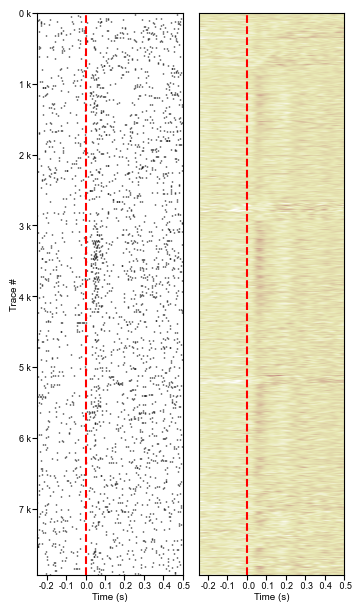

Time since last sync = 358.84 s


In [161]:
input_spike_events = gather_spike_events.reshape((-1,) + (gather_spike_events.shape[-1],) )
input_subthd_dFFs = gather_subthd_dFFs.reshape((-1,) + (gather_subthd_dFFs.shape[-1],) )

# input_spike_events = gather_spike_events[sort_order,:,:].reshape((-1,) + (gather_spike_events.shape[-1],) )
# input_subthd_dFFs = gather_subthd_dFFs[sort_order,:,:].reshape((-1,) + (gather_subthd_dFFs.shape[-1],) )

plot_vmin = -0.05
plot_vmax = +0.1
plot_cmap = truncate_pink_r
plot_spike_color = "black"

# input_spike_events = gather_spike_events[:,2,:]
# input_subthd_dFFs = gather_subthd_dFFs[:,2,:]

plot_spike_events = input_spike_events
plot_subthd_dFFs = input_subthd_dFFs
plot_vline_xpos = res_stim_start_idx
 
plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.arange(-0.2, 0.6, 0.1)
plot_x_ticks = (plot_ts/plot_dt_s + plot_vline_xpos).astype(int)
plot_x_labels = [f"{i_t : 0.1f}" for i_t in plot_ts] 

plot_y_ticks = np.arange(0, plot_subthd_dFFs.shape[0], 1E3)
plot_y_tick_labels = [f"{i_k} k" for i_k in (plot_y_ticks/1E3).astype(int)]

dst_figure_name = f"ve_pre_post_stim_plot"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(
    figsize = (3.5,6),
    constrained_layout=True,
    )

fig_gs = mpl_gridspec.GridSpec(1, 2, 
                               # width_ratios = np.ones((1,)),
                               # height_ratios = [1,3],
                               wspace=0.0, hspace=0.0,
                               figure = fig,
                              )


plot_ax = plt.subplot(fig_gs[0,0])

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 4,
              linewidths = 1)
plt.axvline(plot_vline_xpos, color = "red", linestyle =  "--")
plot_ax.set_xticks(plot_x_ticks)
plot_ax.set_xticklabels(plot_x_labels)
plot_ax.tick_params(axis='both', which='major', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.set_xlabel("Time (s)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)
plot_ax.set_yticks(plot_y_ticks)
plot_ax.set_yticklabels(plot_y_tick_labels)
plot_ax.set_ylabel(r"Trace #", 
                fontsize = plot_axis_label_font_size, 
                fontname = "Arial", labelpad = 0)
plt.ylim([plot_spike_events.shape[0], 0])
plt.xlim([0, plot_spike_events.shape[-1]])

plot_ax = plt.subplot(fig_gs[0,1])
plot_im = plt.imshow(plot_subthd_dFFs,
                           aspect = "auto",
                           # interpolation = "none",
                           cmap = plot_cmap,
                           vmin = plot_vmin,
                           vmax = plot_vmax,
                           alpha = 1,
                          )
plt.axvline(plot_vline_xpos, color = "red", linestyle =  "--")
plot_ax.set_xticks(plot_x_ticks)
plot_ax.set_xticklabels(plot_x_labels)
plot_ax.tick_params(axis='both', which='major', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.set_xlabel("Time (s)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)
plt.ylim([plot_subthd_dFFs.shape[0], 0])
plot_ax.set_yticks([])
plt.xlim([0, plot_subthd_dFFs.shape[-1]])

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 300)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

%notebook $dst_notebook_path

print("plot saved to: " + dst_pdf_figure_path)

plt.show()
SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pickle dump to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp\ve_avg_fr_dff_plot.pickle
plot saved to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\figures_tmp\ve_avg_fr_dff_plot.pdf


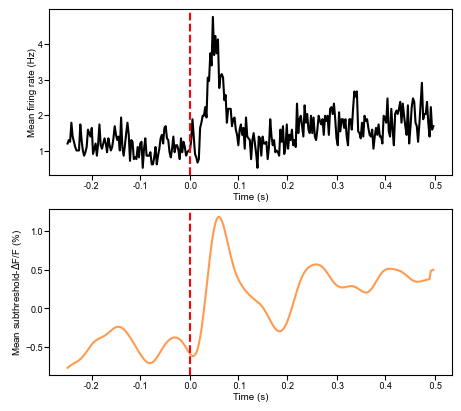

Time since last sync = 561.30 s


In [164]:
plot_dt_s = time_per_frame_ms * ms_to_s
plot_spike_rates = np.mean(gather_spike_events/plot_dt_s, axis = (0,1))
plot_subthd_dFFs = np.mean(gather_subthd_dFFs, axis = (0,1))*1E2

plot_vline_xpos = res_stim_start_idx

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.arange(-0.2, 0.6, 0.1)
plot_x_ticks = (plot_ts/plot_dt_s + plot_vline_xpos).astype(int)
plot_x_labels = [f"{i_t : 0.1f}" for i_t in plot_ts] 

dst_figure_name = f"ve_avg_fr_dff_plot"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(
    figsize = (4.5,4),
    constrained_layout=True,
    )

fig_gs = mpl_gridspec.GridSpec(2, 1, 
                               # width_ratios = np.ones((1,)),
                               # height_ratios = [1,3],
                               wspace=0.0, hspace=0.0,
                               figure = fig,
                              )

plot_ax = plt.subplot(fig_gs[0,0])
plt.plot(plot_spike_rates, 
         color = "black")
plt.axvline(plot_vline_xpos, color = "red", linestyle =  "--")
plot_ax.set_xticks(plot_x_ticks)
plot_ax.set_xticklabels(plot_x_labels)
plot_ax.tick_params(axis='both', which='major', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.set_xlabel("Time (s)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)
plot_ax.set_ylabel("Mean firing rate (Hz)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)

plot_ax = plt.subplot(fig_gs[1,0])
plt.plot()
plt.plot(plot_subthd_dFFs,
         color = r"#FF9B50")
plt.axvline(plot_vline_xpos, color = "red", linestyle =  "--")
plot_ax.set_xticks(plot_x_ticks)
plot_ax.set_xticklabels(plot_x_labels)
plot_ax.set_yticks(np.arange(-0.5, 1.5, 0.5))
plot_ax.tick_params(axis='both', which='major', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                            labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.set_xlabel("Time (s)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)
plot_ax.set_ylabel("Mean subthreshold" + r"-$\mathrm{\Delta}$F/F (%)", 
                        fontsize = plot_axis_label_font_size, 
                        fontname = "Arial", labelpad = 1)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 300)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

%notebook $dst_notebook_path

print("plot saved to: " + dst_pdf_figure_path)

plt.show()
SAVE_PROGRESS(HISTORY_FILEPATH)